In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
import sklearn.metrics as skm

In [2]:
os.chdir('C:/Users/mgp70/OneDrive/Desktop/School/Class Materials/STAT 531')
waino = pd.read_csv('WainoLongitudinal.csv', low_memory=False)
wainoStats = pd.read_html('https://www.baseball-reference.com/players/w/wainwad01-pitch.shtml#players_standard_pitching')
wainoStats = wainoStats[0]
wainoAvgs = pd.read_csv('Waino.csv')

In [3]:
wainoStats = wainoStats[:-2]
wainoStats.iloc[6, wainoStats.columns.get_loc('Season')] = 2011
wainoStats['Season'] = wainoStats['Season'].astype(int)

def inningsPitchedFunction(df):
    strikeouts = df['events'].eq('strikeout').sum()
    fieldouts = df['events'].eq('field_out').sum()
    sacFlies = df['events'].eq('sac_fly').sum()
    sacBunts = df['events'].eq('sac_bunt').sum()
    doublePlays = df['events'].eq('grounded_into_double_play').sum() * 2
    outs = strikeouts + fieldouts + sacFlies + sacBunts + doublePlays
    return outs / 3

er_by_year = wainoStats.set_index('Season')['ER'].to_dict()  
metrics = []
for year, data in waino.groupby('game_year'):
    ip = inningsPitchedFunction(data)
    k = data['events'].eq('strikeout').sum()
    bb = data['events'].isin(['walk', 'hit_by_pitch']).sum()
    hr = data['events'].eq('home_run').sum()
    fip = ((13 * hr) + (3 * bb) - (2 * k)) / ip + 3.1 if ip > 0 else np.nan
    er_value = er_by_year.get(year, np.nan)
    metrics.append({
        'Year': year,
        'ERA': (er_value * 9 / ip) if (ip > 0 and not np.isnan(er_value)) else np.nan,
        'FIP': fip, 
        'Avg_Velocity': data['release_speed'].mean()
        })

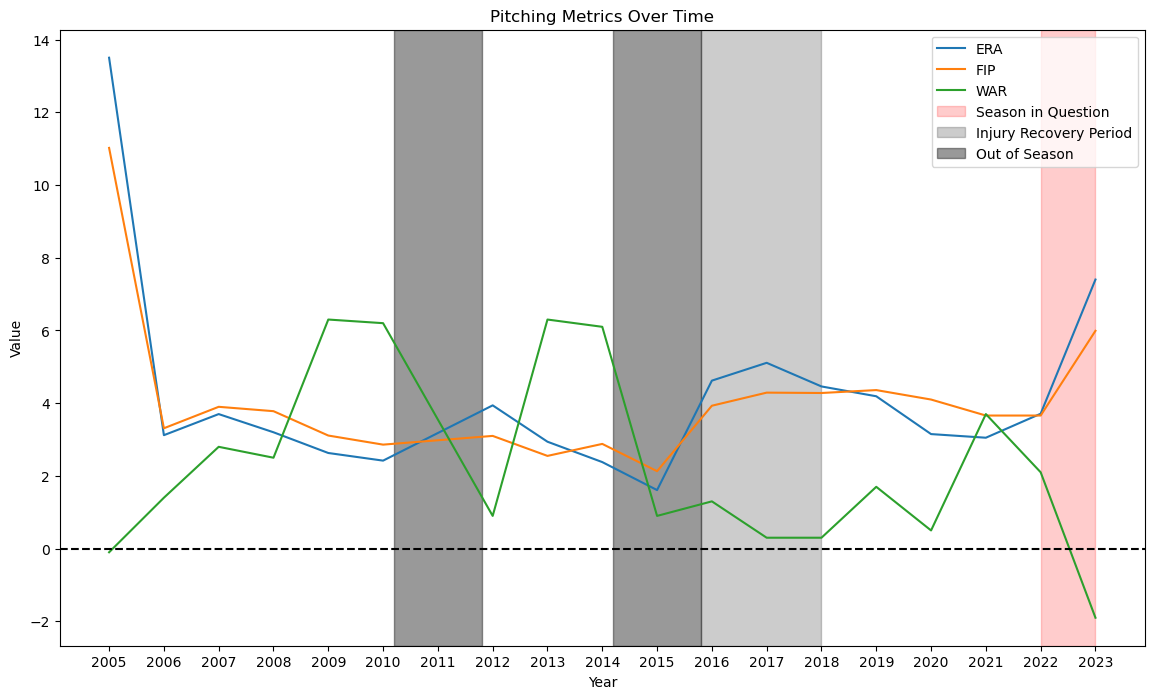

In [4]:
plt.figure(figsize=(14, 8))
for metric in ['ERA', 'FIP', 'WAR']:
    sns.lineplot(data=wainoStats, x='Season', y=metric, label=metric)
plt.xticks(range(2005, 2024))
plt.axvspan(2022, 2023, color='red', alpha=.2, label='Season in Question')
plt.axvspan(2015.8, 2018, color='black', alpha=.2, label='Injury Recovery Period')
plt.axvspan(2014.2, 2015.8, color='black', alpha=.4)
plt.axvspan(2010.2, 2011.8, color='black', alpha=.4, label='Out of Season')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
plt.title('Pitching Metrics Over Time')
plt.ylabel('Value')
plt.xlabel('Year')
plt.legend()
plt.show()

In [5]:
monthlyMetrics = []
waino['game_date'] = pd.to_datetime(waino['game_date'], format='%m/%d/%Y')
waino['year_month'] = waino['game_date'].dt.to_period('M')
for month, data in waino.groupby('year_month'):
    ip = inningsPitchedFunction(data)
    k = data['events'].eq('strikeout').sum()
    bb = data['events'].isin(['walk', 'hit_by_pitch']).sum()
    hr = data['events'].eq('home_run').sum()
    fip = ((13 * hr) + (3 * bb) - (2 * k)) / ip + 3.1 if ip > 0 else np.nan
    monthlyMetrics.append({
        'Month': month,
        'FIP': fip, 
        'Avg_Velocity': data['release_speed'].mean()
        })
monthlyMetrics = pd.DataFrame(monthlyMetrics)

In [6]:
print(type(monthlyMetrics))
print(monthlyMetrics)

<class 'pandas.core.frame.DataFrame'>
      Month       FIP  Avg_Velocity
0   2008-04  3.650459     85.894737
1   2008-05  3.804348     86.178794
2   2008-06  4.561538     86.900629
3   2008-08  3.736364     86.812422
4   2008-09  3.421429     86.007475
..      ...       ...           ...
78  2023-05  4.112987     80.906579
79  2023-06  6.680645     81.129040
80  2023-07  7.355814     81.489388
81  2023-08  6.209091     80.319783
82  2023-09  6.394118     80.258419

[83 rows x 3 columns]


In [7]:
print(monthlyMetrics.dtypes)

Month           period[M]
FIP               float64
Avg_Velocity      float64
dtype: object


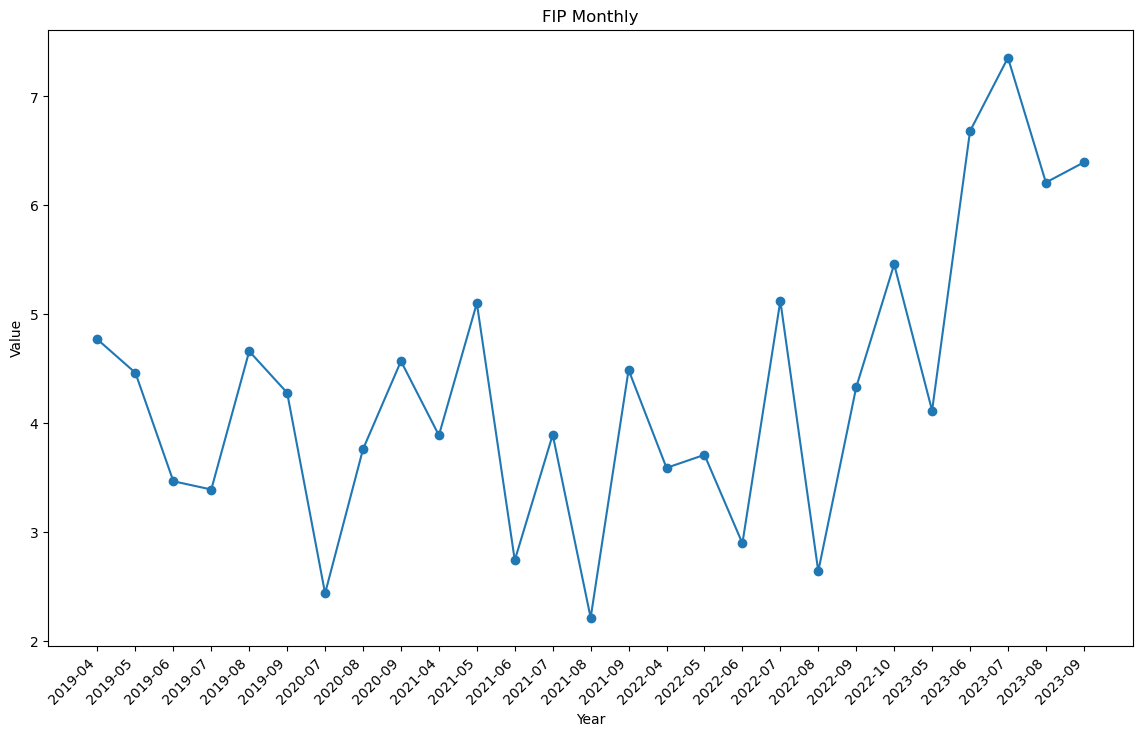

In [8]:
april_labels = str(monthlyMetrics[(monthlyMetrics['Month'] >= '2019-04-01')])
pltMonthlyMetrics = monthlyMetrics[(monthlyMetrics['Month'] >= '2019-04-01')].copy()  # Create a copy
pltMonthlyMetrics.loc[:, 'x_value'] = range(len(pltMonthlyMetrics))  # Sequential index with .loc
pltMonthlyMetrics.loc[:, 'MonthLabel'] = pltMonthlyMetrics['Month'].dt.strftime('%Y-%m')  # Use .loc
plt.figure(figsize=(14,8))
plt.plot(pltMonthlyMetrics['x_value'], pltMonthlyMetrics['FIP'], label='Wainwright Average FIP Monthly', marker='o', linestyle='-')
plt.xticks(pltMonthlyMetrics['x_value'], pltMonthlyMetrics['MonthLabel'], rotation=45, ha='right')
plt.title('FIP Monthly')
plt.ylabel('Value')
plt.xlabel('Year')
plt.show()
warnings.filterwarnings('ignore')

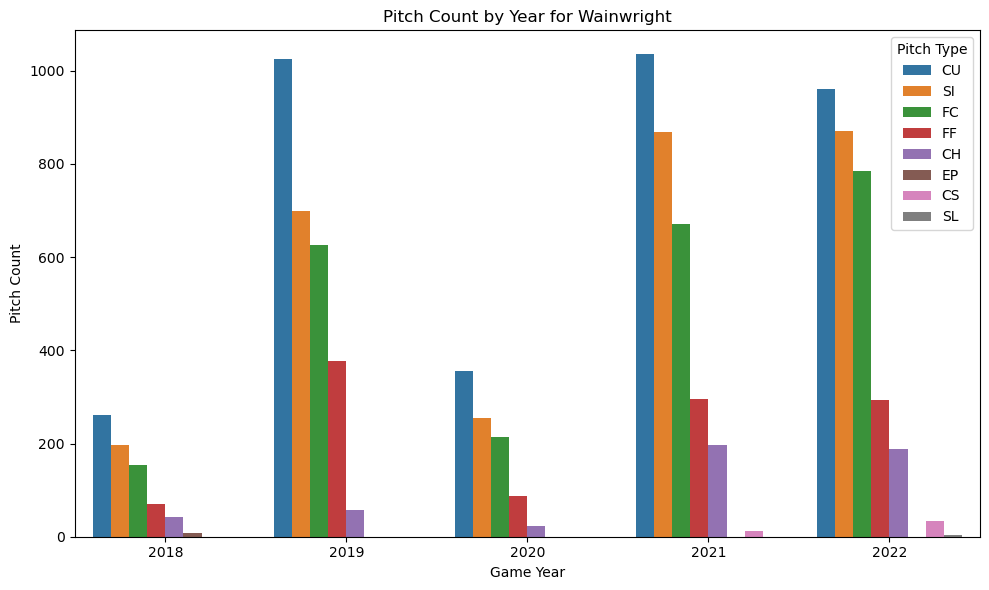

In [9]:
pitch_count_by_year = waino.groupby('game_year')['pitch_type'].value_counts().reset_index(name='count')
filtered_data = pitch_count_by_year[pitch_count_by_year['game_year'].isin(range(2018, 2023))]
plt.figure(figsize=(10, 6))
sns.barplot(x='game_year', y='count', hue='pitch_type', data=filtered_data)
plt.xlabel('Game Year')
plt.ylabel('Pitch Count')
plt.title('Pitch Count by Year for Wainwright')
plt.legend(title='Pitch Type')
plt.tight_layout()
plt.show()

In [10]:
sinkers = waino[waino['pitch_type']=='SI']
wainoVelocity = {year: data['release_speed'].mean() for year, data in sinkers.groupby('game_year')}
wainoVelocity = pd.DataFrame.from_dict(wainoVelocity, orient='index', columns=['Avg_Velocity'])

os.chdir('C:/Users/mgp70/OneDrive/Desktop/School/Class Materials/STAT 531/Velocity')
compPitchersStatsDict={}
compPitchersStats={}
for year in range(2018, 2023):
    compPitchersStatsDict[year] = pd.read_csv(f"{year}A.csv", low_memory=False)
    compPitchersStats = pd.concat([pd.DataFrame(compPitchersStats), pd.DataFrame(compPitchersStatsDict[year])])
empty_columns = ['bat_speed', 'swing_length', 'arm_angle']
compPitchersStats = compPitchersStats.drop(columns=empty_columns)
velocityCompPitchersStats = compPitchersStats[compPitchersStats['player_name'] != 'Wainwright, Adam']
velocityCompPitchersStats = velocityCompPitchersStats[velocityCompPitchersStats['pitch_type'] == 'SI']
velocity_means = {year: data['release_speed'].mean() for year, data in velocityCompPitchersStats.groupby('game_year')}
velocity_means = pd.DataFrame.from_dict(velocity_means, orient='index', columns=['Avg_Velocity'])
print(velocity_means)

      Avg_Velocity
2018     91.691854
2019     91.728429
2020     90.793238
2021     90.234787
2022     90.113659


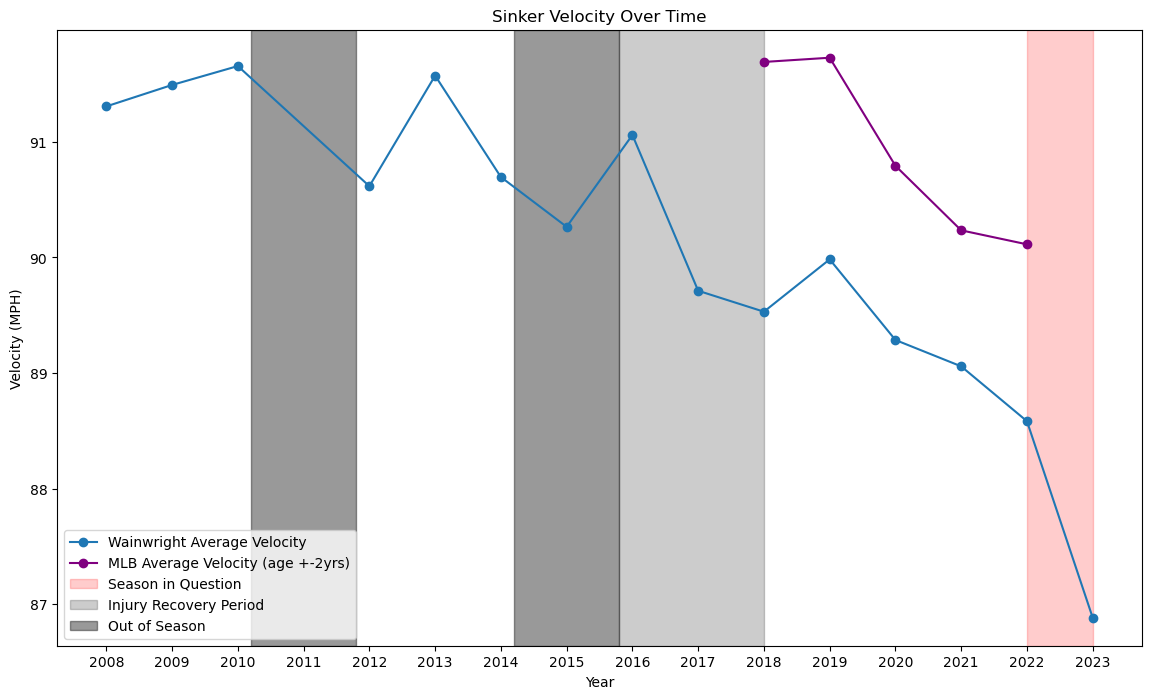

In [11]:
plt.figure(figsize=(14,8))
plt.plot(wainoVelocity.index, wainoVelocity['Avg_Velocity'], label='Wainwright Average Velocity', marker='o', linestyle='-')
plt.plot(range(2018,2023), velocity_means.values, marker='o', linestyle='-', label="MLB Average Velocity (age +-2yrs)", color="purple")
plt.xticks(range(2005, 2024))
plt.axvspan(2022, 2023, color='red', alpha=.2, label='Season in Question')
plt.axvspan(2015.8, 2018, color='black', alpha=.2, label='Injury Recovery Period')
plt.axvspan(2014.2, 2015.8, color='black', alpha=.4)
plt.axvspan(2010.2, 2011.8, color='black', alpha=.4, label='Out of Season')
plt.title('Sinker Velocity Over Time')
plt.ylabel('Velocity (MPH)')
plt.xlabel('Year')
plt.legend()
plt.show()

In [12]:
velocity = {}  
for year in range(2018, 2023):
    velocity[year] = pd.read_csv(f"{year}.csv", low_memory=False)
target_pitcher_id = 425794
all_years_data = []
scaler = StandardScaler()

for year in range(2018, 2023):
    pitcher_data = velocity[year]
    empty_columns = ['bat_speed', 'swing_length', 'arm_angle'] #no data available from Baseball Savant (columns completely empty)
    pitcher_data = pitcher_data.drop(columns=empty_columns)
    pitcher_data = pitcher_data[pitcher_data['player_id'] != 489334]
    
    # Have to fix the NAs
    numeric_columns = pitcher_data.select_dtypes(include=['number']).columns
    player_means = pitcher_data.groupby('player_id')[numeric_columns].mean()
    pitcher_data_filled = pitcher_data.copy()
    for player_id in pitcher_data['player_id'].unique():
        player_mean = player_means.loc[player_id]  
        pitcher_data_filled.loc[pitcher_data_filled['player_id'] == player_id, pitcher_data_filled.columns.difference(['player_id', 'player_name'])] = pitcher_data_filled.loc[pitcher_data_filled['player_id'] == player_id, pitcher_data_filled.columns.difference(['player_id', 'player_name'])].fillna(player_mean)
    all_years_data.append(pitcher_data_filled)
    
    pitcher_data_filled = pitcher_data_filled.dropna()
    pitcher_data_numeric = pitcher_data_filled.drop(columns=['player_id', 'player_name'])
    pitcher_data_scaled = scaler.fit_transform(pitcher_data_numeric)
    knn = NearestNeighbors(n_neighbors=2)  
    knn.fit(pitcher_data_scaled)
    
    target_pitcher = pitcher_data_filled[pitcher_data_filled['player_id'] == target_pitcher_id].drop(columns=['player_id', 'player_name'])
    target_pitcher_scaled = scaler.transform(target_pitcher)
    distances, indices = knn.kneighbors(target_pitcher_scaled)
    
    most_similar_pitcher_id = pitcher_data_filled.iloc[indices[0][1]]['player_id']  
    most_similar_pitcher_name = pitcher_data_filled[pitcher_data_filled['player_id'] == most_similar_pitcher_id]['player_name'].values[0]  
    
    print(f'Most similar pitcher ID in {year}: {most_similar_pitcher_id}, Name: {most_similar_pitcher_name}')
    print(f'Distances in {year}:', distances[0][1])

# Combine all years' data
combined_data = pd.concat(all_years_data)
combined_data = combined_data.dropna()
numeric_columns = combined_data.select_dtypes(include=['number']).columns
combined_data_numeric = combined_data[numeric_columns]
columns_to_drop = ['player_id', 'player_name']
combined_data_numeric = combined_data_numeric.drop(columns=[col for col in columns_to_drop if col in combined_data_numeric.columns])
combined_data_scaled = scaler.fit_transform(combined_data_numeric)

knn = NearestNeighbors(n_neighbors=2) 
knn.fit(combined_data_scaled)
target_pitcher = combined_data[combined_data['player_id'] == target_pitcher_id]
target_pitcher_numeric = target_pitcher.drop(columns=columns_to_drop, errors='ignore')  
target_pitcher_scaled = scaler.transform(target_pitcher_numeric)

distances, indices = knn.kneighbors(target_pitcher_scaled)
most_similar_pitcher_id = combined_data.iloc[indices[0][1]]['player_id'] 
most_similar_pitcher_name = combined_data[combined_data['player_id'] == most_similar_pitcher_id]['player_name'].values[0]  # Get the player's name

print(f'Most similar pitcher ID across all years: {most_similar_pitcher_id}, Name: {most_similar_pitcher_name}')
print(f'Distances across all years: {distances[0][1]}') 

Most similar pitcher ID in 2018: 445926, Name: Chavez, Jesse
Distances in 2018: 10.317726125000023
Most similar pitcher ID in 2019: 434671, Name: Sánchez, Aníbal
Distances in 2019: 5.672195080570312
Most similar pitcher ID in 2020: 450203, Name: Morton, Charlie
Distances in 2020: 8.674006434624674
Most similar pitcher ID in 2021: 501925, Name: Smith, Joe
Distances in 2021: 8.691487366882493
Most similar pitcher ID in 2022: 425844, Name: Greinke, Zack
Distances in 2022: 9.005582714171894
Most similar pitcher ID across all years: 434671, Name: Sánchez, Aníbal
Distances across all years: 9.022691773534373


In [13]:
player_names_to_include = [
    'Chavez, Jesse',
    'Sánchez, Aníbal',
    'Morton, Charlie',
    'Smith, Joe',
    'Greinke, Zack', 
    'Wainwright, Adam'
]
includedPitchersStats = compPitchersStats[compPitchersStats['player_name'].isin(player_names_to_include)]
pitch_types = ['CU', 'SI', 'FC']

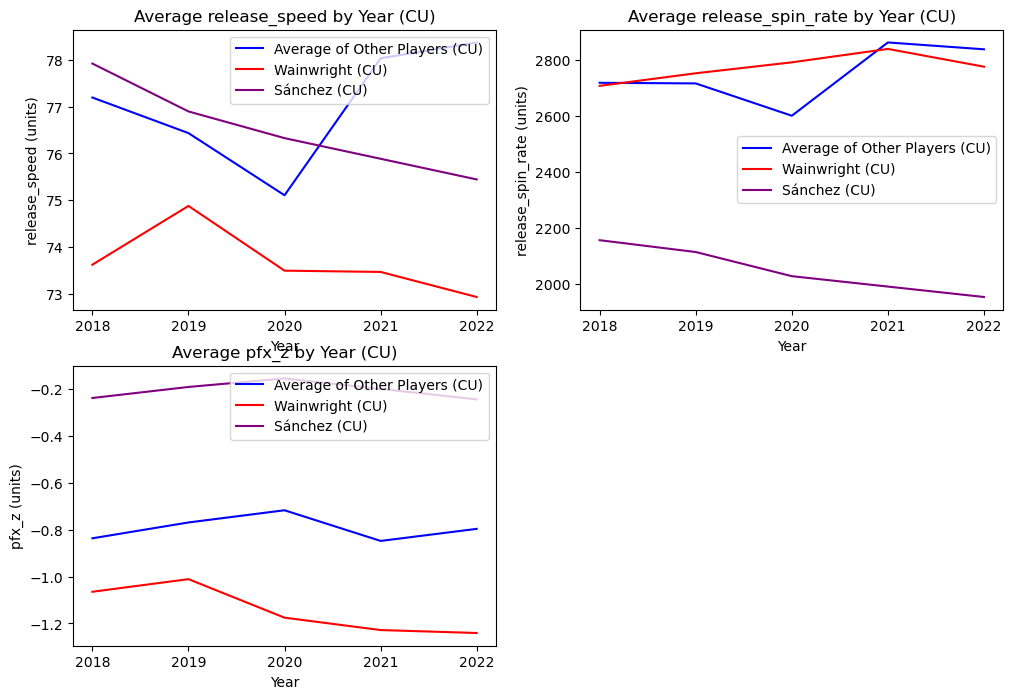

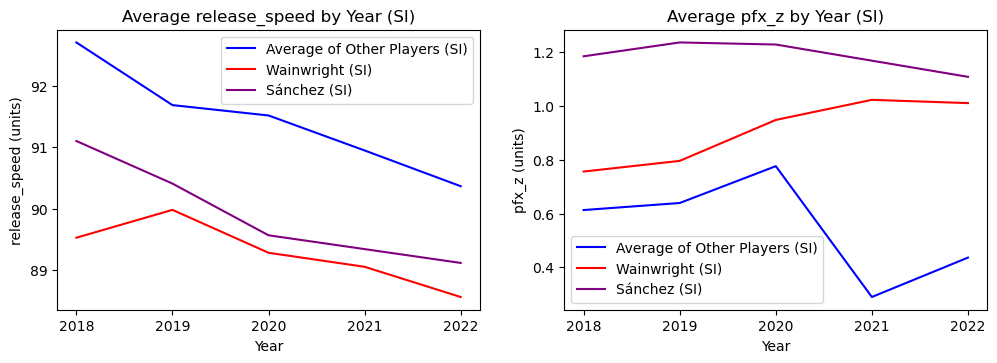

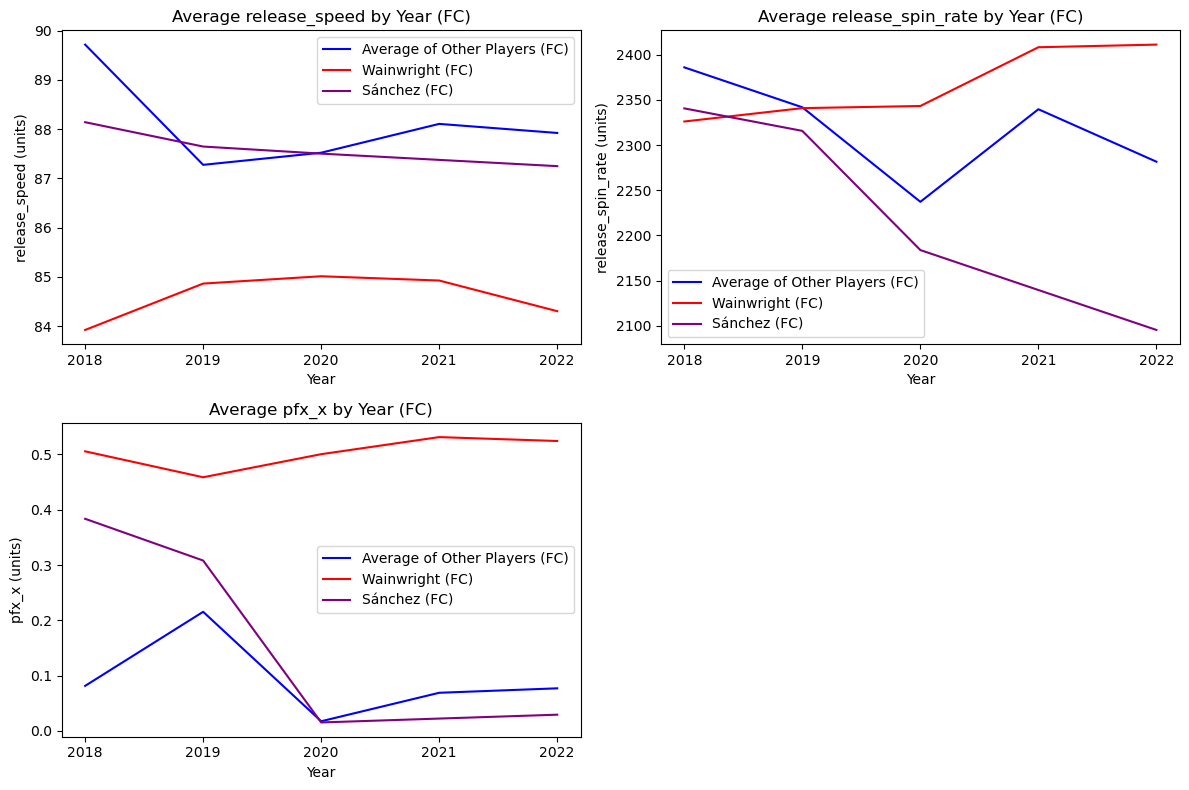

In [14]:
metrics_dict = {
    'CU': ['release_speed', 'release_spin_rate', 'pfx_z'],  # For curveball
    'SI': ['release_speed', 'pfx_z'],  # For sinker
    'FC': ['release_speed', 'release_spin_rate', 'pfx_x'],  # For cutter
}
for pitch_type in pitch_types:
    pitch_filtered = includedPitchersStats[includedPitchersStats['pitch_type'] == pitch_type]
    other_players = pitch_filtered[pitch_filtered['player_name'] != 'Wainwright, Adam']
    averaged_other_players = other_players.groupby(['game_year'])[metrics_dict[pitch_type]].mean().reset_index()

    wainwright_data = pitch_filtered[pitch_filtered['player_name'] == 'Wainwright, Adam'].groupby('game_year')[metrics_dict[pitch_type]].mean().reset_index()
    sánchez_data = pitch_filtered[pitch_filtered['player_name'] == 'Sánchez, Aníbal'].groupby('game_year')[metrics_dict[pitch_type]].mean().reset_index()
    plt.figure(figsize=(12, 8))
    for metric in metrics_dict[pitch_type]:
        plt.subplot(2, 2, metrics_dict[pitch_type].index(metric) + 1)  
        plt.xticks(range(2018, 2023))
        sns.lineplot(x='game_year', y=metric, data=averaged_other_players, label=f'Average of Other Players ({pitch_type})', color='blue')
        sns.lineplot(x='game_year', y=metric, data=wainwright_data, label=f'Wainwright ({pitch_type})', color='red')
        sns.lineplot(x='game_year', y=metric, data=sánchez_data, label=f'Sánchez ({pitch_type})', color='purple')
        plt.title(f'Average {metric} by Year ({pitch_type})')
        plt.xlabel('Year')
        plt.ylabel(f'{metric} (units)')

plt.tight_layout()
plt.legend()
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries, significance=0.05):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= significance:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data is non-stationary")

In [16]:
from statsmodels.tsa.api import VAR
statsToModel = ['ERA', 'FIP', 'WAR']
modelingWainoStatsOld = wainoStats.drop([6, 18]).copy()
modelingWainoStatsOld['Age'] = pd.to_numeric(modelingWainoStatsOld['Age'], errors='coerce')
modelingWainoStatsOld.set_index("Season", inplace=True)
modelingWainoStatsOld = modelingWainoStatsOld.drop(['Awards', 'Team', 'Lg', 'W-L%'], axis=1)

In [17]:
allDF = []
for pitch, data in waino.groupby('pitch_type'):
    temp = {year: data['release_speed'].mean() for year, data in data.groupby('game_year')}
    df = pd.DataFrame.from_dict(temp, orient='index', columns=[f'{pitch}_Avg_Velocity'])
    allDF.append(df)
allWainoVelocity = pd.concat(allDF, axis=1)
allWainoVelocity.dropna(inplace=True, axis=1)
modelingWainoStats = modelingWainoStatsOld.join(allWainoVelocity) #only includes from 2008 onward (not including 2005-2007)
modelingWainoStats.dropna(inplace=True)
columns_to_standardize = [col for col in modelingWainoStats.columns if col not in statsToModel]
modelingWainoStats[columns_to_standardize] = scaler.fit_transform(modelingWainoStats[columns_to_standardize])

In [18]:
adfData = modelingWainoStats.copy()
adfData = adfData.loc[:, adfData.nunique() > 1]
for column in adfData.select_dtypes(include=['number']).columns:  
    print(f'column: {column}')
    adf_test(adfData[column])

column: Age
ADF Statistic: -1.635358
p-value: 0.464687
Critical Values:
	1%: -4.138
	5%: -3.155
	10%: -2.714
Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data is non-stationary
column: WAR
ADF Statistic: -3.018830
p-value: 0.033173
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
column: W
ADF Statistic: -32.180021
p-value: 0.000000
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
column: L
ADF Statistic: -2.436555
p-value: 0.131684
Critical Values:
	1%: -4.473
	5%: -3.290
	10%: -2.772
Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data is non-stationary
column: ERA
ADF Statistic: -2.226284
p-value: 0.196844
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702
Weak evidence against the null hypothesis, fail to reject the null hyp

In [19]:
#test checking for colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
wainoStats1 = {}
X = modelingWainoStats
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
warnings.filterwarnings("ignore")

           Variable  VIF
0               Age  inf
1               WAR  inf
2                 W  inf
3                 L  inf
4               ERA  inf
5                 G  inf
6                GS  inf
7                GF  inf
8                CG  inf
9               SHO  inf
10               SV  NaN
11               IP  inf
12                H  inf
13                R  inf
14               ER  inf
15               HR  inf
16               BB  inf
17              IBB  inf
18               SO  inf
19              HBP  inf
20               BK  inf
21               WP  inf
22               BF  inf
23             ERA+  inf
24              FIP  inf
25             WHIP  inf
26               H9  inf
27              HR9  inf
28              BB9  inf
29              SO9  inf
30            SO/BB  inf
31  CH_Avg_Velocity  inf
32  CU_Avg_Velocity  inf
33  FC_Avg_Velocity  inf
34  FF_Avg_Velocity  inf
35  SI_Avg_Velocity  inf


In [21]:
lagModelingWainoStats = modelingWainoStats.sort_values(by='Season').copy()
# Create Lagged Features (using past 3 seasons)
lags = 3
for stat in statsToModel:
    for lag in range(1, lags + 1):
        lagModelingWainoStats[f"{stat}_lag{lag}"] = lagModelingWainoStats[stat].shift(lag)

# Train-Test Split (Time-Based, not Random)
train_size = int(0.8 * len(lagModelingWainoStats))
train, test = lagModelingWainoStats.iloc[:train_size], lagModelingWainoStats.iloc[train_size:]

X_train, y_train = train.drop(columns=statsToModel), train[statsToModel]
X_test, y_test = test.drop(columns=statsToModel), test[statsToModel]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Model Performance
y_test_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Feature Importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
feature_names = X_train.columns[sorted_idx]

print("Feature Importances:", list(zip(feature_names, feature_importance[sorted_idx])))

# Predict the Next Season (Using Last Available Season Data)
last_season = X_test.iloc[-1, :].values.reshape(1, -1)  # Use the most recent season
next_season_pred = rf_model.predict(last_season)

print("Predicted Next Season Stats:", dict(zip(statsToModel, next_season_pred[0])))

Root Mean Squared Error: 0.6075957254256779
Feature Importances: [('W', 0.1687728965769005), ('FF_Avg_Velocity', 0.12310810199861441), ('BF', 0.08583793863491175), ('IP', 0.06757727097697795), ('SO', 0.06011469555287651), ('ERA+', 0.0462381949440202), ('H9', 0.03898910144028663), ('CG', 0.03224306754924509), ('Age', 0.03160499328496294), ('BB9', 0.027810894207374988), ('SO/BB', 0.025763396701603464), ('HR9', 0.025525892595359877), ('SI_Avg_Velocity', 0.024552515175859324), ('SHO', 0.023915638110409424), ('CU_Avg_Velocity', 0.02343251098664647), ('WHIP', 0.020137152785426778), ('GS', 0.01590680729426859), ('ERA_lag1', 0.015206736939736116), ('H', 0.01517161382923707), ('ERA_lag3', 0.01396375976256221), ('WP', 0.013140042497772836), ('ER', 0.011517592187981257), ('BB', 0.011047135161723008), ('SO9', 0.010596407214039538), ('G', 0.009189175276382666), ('L', 0.009009763791316015), ('WAR_lag2', 0.007658483708692127), ('HBP', 0.007419656343285118), ('GF', 0.005969132318064858), ('ERA_lag2', 

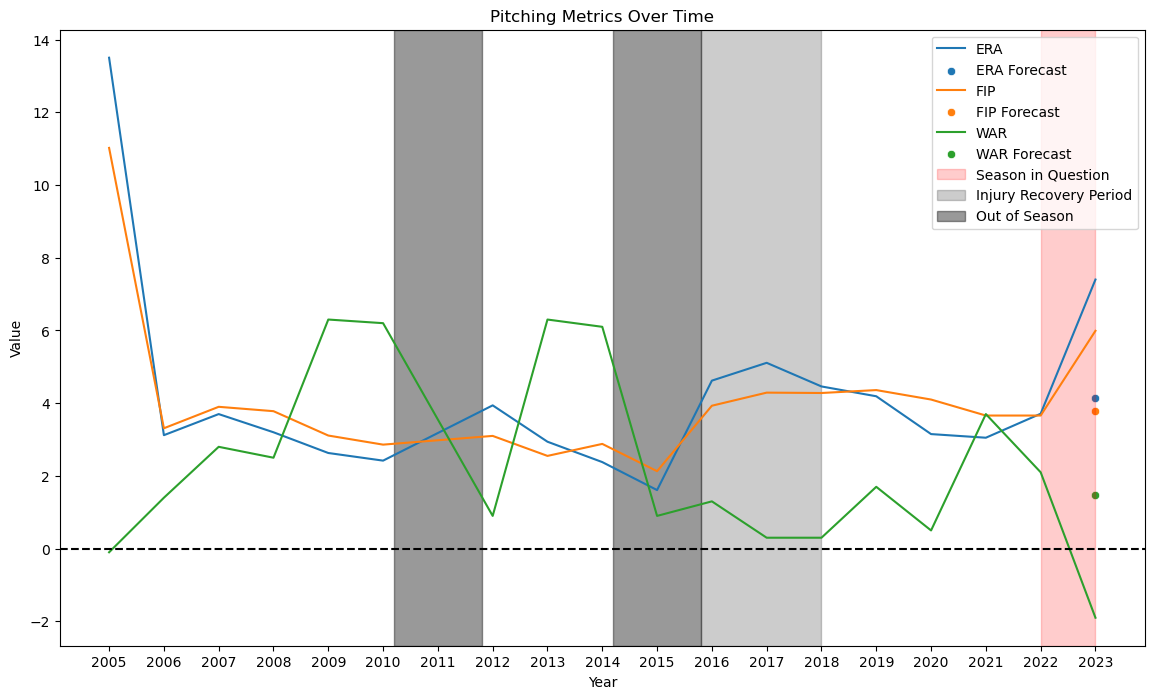

In [22]:
next_season_pred = pd.DataFrame({'Metric': statsToModel, 'Prediction': next_season_pred[0]})
plt.figure(figsize=(14, 8))
for metric in ['ERA', 'FIP', 'WAR']:
    sns.lineplot(data=wainoStats, x='Season', y=metric, label=metric)
    
    sns.scatterplot(
        data=next_season_pred[next_season_pred['Metric'] == metric],  # Ensure predictions are for the same metric
        x=2023, 
        y='Prediction', 
        label=f'{metric} Forecast'
    )
plt.xticks(range(2005, 2024))
plt.axvspan(2022, 2023, color='red', alpha=.2, label='Season in Question')
plt.axvspan(2015.8, 2018, color='black', alpha=.2, label='Injury Recovery Period')
plt.axvspan(2014.2, 2015.8, color='black', alpha=.4)
plt.axvspan(2010.2, 2011.8, color='black', alpha=.4, label='Out of Season')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
plt.title('Pitching Metrics Over Time')
plt.ylabel('Value')
plt.xlabel('Year')
plt.legend()
plt.show()

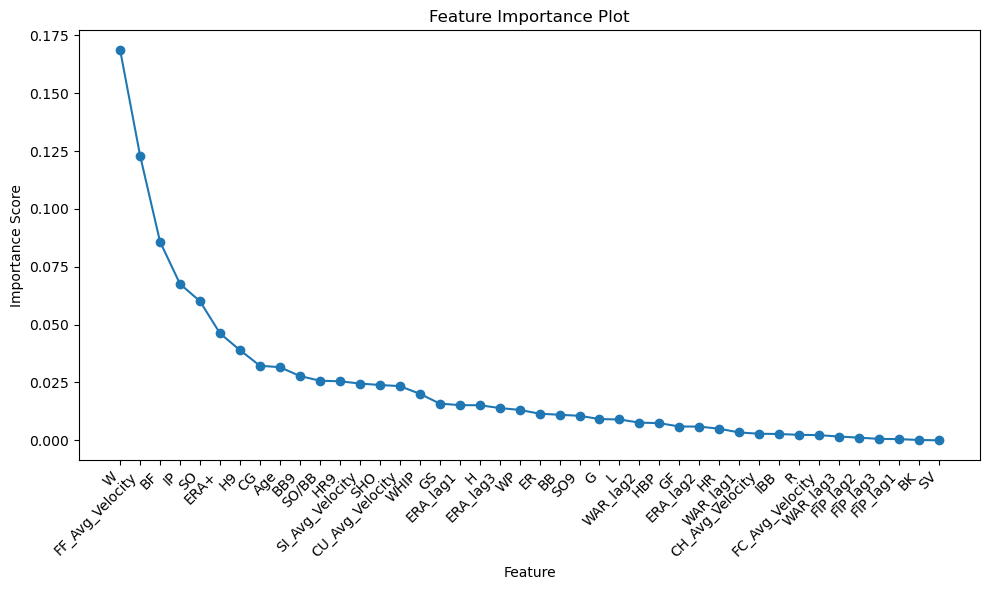

In [23]:
important = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
important = important.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.plot(important['Feature'], important['Importance'], marker='o')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance Plot')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
print(important)

            Feature  Importance
1                 W    0.168773
31  FF_Avg_Velocity    0.123108
20               BF    0.085838
9                IP    0.067577
16               SO    0.060115
21             ERA+    0.046238
23               H9    0.038989
6                CG    0.032243
0               Age    0.031605
25              BB9    0.027811
27            SO/BB    0.025763
24              HR9    0.025526
32  SI_Avg_Velocity    0.024553
7               SHO    0.023916
29  CU_Avg_Velocity    0.023433
22             WHIP    0.020137
4                GS    0.015907
33         ERA_lag1    0.015207
10                H    0.015172
35         ERA_lag3    0.013964
19               WP    0.013140
12               ER    0.011518
14               BB    0.011047
26              SO9    0.010596
3                 G    0.009189
2                 L    0.009010
40         WAR_lag2    0.007658
17              HBP    0.007420
5                GF    0.005969
34         ERA_lag2    0.005947
13      

In [25]:
statsToUse = important[important['Importance']>.025]

In [26]:
statsToUse = statsToUse['Feature'].tolist()
print(statsToUse)

['W', 'FF_Avg_Velocity', 'BF', 'IP', 'SO', 'ERA+', 'H9', 'CG', 'Age', 'BB9', 'SO/BB', 'HR9']


In [27]:
X = modelingWainoStats[statsToUse]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

           Variable          VIF
0                 W    27.400538
1   FF_Avg_Velocity    15.519719
2                BF  7926.154382
3                IP  5801.701786
4                SO   374.779409
5              ERA+    41.433333
6                H9    34.115604
7                CG    50.846720
8               Age     9.246571
9               BB9    57.596579
10            SO/BB    60.879181
11              HR9    13.079493


In [28]:
statsToUse = vif_data[vif_data['VIF']<50]
statsToUse = statsToUse['Variable'].tolist()
X = modelingWainoStats[statsToUse]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Variable       VIF
0                W  1.948580
1  FF_Avg_Velocity  3.324648
2             ERA+  5.922770
3               H9  2.397534
4              Age  2.655119
5              HR9  4.021998


In [29]:
varWainoStats = modelingWainoStats.loc[:, statsToModel]
varWainoStats = varWainoStats.join(modelingWainoStats[statsToUse])

model = VAR(varWainoStats[statsToModel])

lag_selection = model.select_order(maxlags=2)
print(lag_selection)
best_lag = lag_selection.aic if lag_selection.aic != 0 else 1

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 2, FPE -> 2, HQIC ->  2>


In [30]:
var_model = model.fit(best_lag)

forecast = var_model.forecast(varWainoStats[statsToModel].values[-lag_selection.aic:], steps=1)
print(forecast)
print('R-squared')
print(f'ERA: {skm.r2_score(var_model.fittedvalues['ERA']+var_model.resid['ERA'],
  var_model.fittedvalues['ERA'])}')
print(f'FIP: {skm.r2_score(var_model.fittedvalues['FIP']+var_model.resid['FIP'],
  var_model.fittedvalues['FIP'])}')
print(f'WAR: {skm.r2_score(var_model.fittedvalues['WAR']+var_model.resid['WAR'],
  var_model.fittedvalues['WAR'])}')

[[3.73104483 3.4322728  3.01037813]]
R-squared
ERA: 0.5201224733568031
FIP: 0.7298116209803867
WAR: 0.43049295260994913


In [31]:
from pygam import LinearGAM, s
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X = modelingWainoStats.drop(columns=statsToModel)
y = modelingWainoStats[statsToModel]
for i, target in enumerate(statsToModel):
    print(f"Fitting model for {target}")
    y_single = y[target].values 
    X_train, X_test, y_train, y_test = train_test_split(X, y_single, test_size=0.2, shuffle=False)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4), fit_intercept=True).fit(X_train_pca, y_train)
    y_pred = gam.predict(X_test_pca)
    gam.summary()

    X_pca_single = pca.transform(X.iloc[-1:].values)
    X_pca_single = pd.DataFrame(X_pca_single, columns=[f"PC{i+1}" for i in range(X_pca_single.shape[1])])
    next_season_pred = gam.predict(X_pca_single)
    print(f"Predicted stats for the next season for {target}: {next_season_pred}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

Fitting model for ERA
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.0487
Link Function:                     IdentityLink Log Likelihood:                                   -16.6444
Number of Samples:                           11 AIC:                                               37.3863
                                                AICc:                                              38.9574
                                                GCV:                                                1.5278
                                                Scale:                                               1.268
                                                Pseudo R-Squared:                                  -0.0095
Feature Functio

In [32]:
numerical_columns = modelingWainoStats.select_dtypes(include=['int64', 'float64']).columns
modelingWainoStats[numerical_columns] = modelingWainoStats[numerical_columns].astype(float)

X = modelingWainoStats[statsToUse]  # Predictors
y = modelingWainoStats[statsToModel]  # Targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, enable_categorical=True, random_state = 15)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(y_pred)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

next_season_stats = X.iloc[-1:].copy()  # Use the most recent season as a reference
forecast = xgb_model.predict(next_season_stats)
print(f'Predicted {statsToModel} for next season:', forecast)

[[3.023785  3.6365342 2.2752025]
 [2.5102873 2.6196032 6.2859664]
 [2.3821297 2.8802621 6.096713 ]]
Mean Squared Error: 0.25542399287223816
Predicted ['ERA', 'FIP', 'WAR'] for next season: [[3.7098417 3.6604614 2.1003597]]


In [33]:
print(modelingWainoStats)

             Age  WAR         W         L   ERA         G        GS        GF  \
Season                                                                          
2008   -1.681420  2.5 -0.298105 -1.243987  3.20 -0.590862 -0.537995 -0.277350   
2009   -1.450637  6.3  1.037406  0.160514  2.63  0.821442  0.813890 -0.277350   
2010   -1.219854  6.2  1.204345  1.003215  2.42  0.720563  0.717327 -0.277350   
2012   -0.758288  0.9  0.202712  1.565016  3.94  0.619684  0.620763 -0.277350   
2013   -0.527504  6.3  1.037406  0.441415  2.94  0.821442  0.813890 -0.277350   
2014   -0.296721  6.1  1.204345  0.441415  2.38  0.619684  0.620763 -0.277350   
2015   -0.065938  0.9 -1.800556 -1.805788  1.61 -1.902286 -2.083006  3.605551   
2016    0.164845  1.3  0.035773  0.441415  4.62  0.720563  0.717327 -0.277350   
2017    0.395628  0.3 -0.131166 -0.682187  5.11 -0.187346 -0.248305 -0.277350   
2018    0.626411  0.3 -1.800556 -0.963087  4.46 -1.801407 -1.696753 -0.277350   
2019    0.857195  1.7  0.202

In [34]:
from sklearn.model_selection import cross_val_score

X = modelingWainoStats[statsToUse]  # Predictors
y = modelingWainoStats[statsToModel]  # Targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, enable_categorical=True, random_state = 15)

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(f'Cross-validation MSE: {-cv_scores.mean()}')
print(f'Cross-validation standard deviation: {cv_scores.std()}')

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(y_pred)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

next_season_stats = X.iloc[-1:].copy()  # Use the most recent season as a reference
forecast = xgb_model.predict(next_season_stats)
print(f'Predicted {statsToModel} for next season:', forecast)

Cross-validation MSE: 0.9411368906497956
Cross-validation standard deviation: 0.5710925535039303
[[2.941264   2.746687   6.2241583 ]
 [4.816907   2.640301   0.30952615]
 [2.941264   2.6668146  6.197175  ]]
Mean Squared Error: 0.3652973175048828
Predicted ['ERA', 'FIP', 'WAR'] for next season: [[3.7098103 3.660463  2.1003537]]


In [35]:
num_iterations = 10
mse_results = []
forecast_results = {stat: [] for stat in statsToModel}

for i in range(num_iterations):
    print(f"Iteration {i+1}/{num_iterations}")

    X = modelingWainoStats[statsToUse]  # Predictors
    y = modelingWainoStats[statsToModel]  # Targets (multiple columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, enable_categorical=True, random_state=15)
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')  # Averages across multiple outputs
    print(f"Mean Squared Error: {mse}")

    next_season_stats = X.iloc[-1:].copy()
    forecast = xgb_model.predict(next_season_stats)  # This will be an array with multiple values
    print(f'Predicted {statsToModel} for next season:', forecast.flatten())

    mse_results.append(mse)
    for idx, stat in enumerate(statsToModel):
        forecast_results[stat].append(forecast[0][idx])  # Store each stat's forecast separately

print("\nFinal Statistics After Multiple Iterations:")
print(f"MSE - Min: {min(mse_results)}, Max: {max(mse_results)}, Avg: {np.mean(mse_results)}")
for stat in statsToModel:
    print(f"{stat} Forecast - Min: {min(forecast_results[stat])}, Max: {max(forecast_results[stat])}, Avg: {np.mean(forecast_results[stat])}")

Iteration 1/10
Mean Squared Error: 0.5373597741127014
Predicted ['ERA', 'FIP', 'WAR'] for next season: [3.7097816 3.6603882 2.1006398]
Iteration 2/10
Mean Squared Error: 0.6845579147338867
Predicted ['ERA', 'FIP', 'WAR'] for next season: [4.128143   3.9532816  0.53018826]
Iteration 3/10
Mean Squared Error: 0.24747653305530548
Predicted ['ERA', 'FIP', 'WAR'] for next season: [3.7098186 3.6598668 2.1009123]
Iteration 4/10
Mean Squared Error: 1.0009135007858276
Predicted ['ERA', 'FIP', 'WAR'] for next season: [3.709887  3.6601813 2.1000748]
Iteration 5/10
Mean Squared Error: 0.7084290385246277
Predicted ['ERA', 'FIP', 'WAR'] for next season: [4.157203  3.935591  0.5127635]
Iteration 6/10
Mean Squared Error: 0.8222055435180664
Predicted ['ERA', 'FIP', 'WAR'] for next season: [3.7098844 3.6603024 2.100369 ]
Iteration 7/10
Mean Squared Error: 0.14035218954086304
Predicted ['ERA', 'FIP', 'WAR'] for next season: [3.709776  3.6600726 2.099831 ]
Iteration 8/10
Mean Squared Error: 1.0453830957412

In [36]:
prediction = {}
for stat in statsToModel:
    prediction[stat] = np.mean(forecast_results[stat])

plotForecast = pd.DataFrame({
    'Season': [2023] * len(statsToModel),
    'Metric': list(prediction.keys()),  # Extracts the stat names
    'Prediction': list(prediction.values())  # Extracts the predicted values
})
print(plotForecast)

   Season Metric  Prediction
0    2023    ERA    3.917875
1    2023    FIP    3.809401
2    2023    WAR    1.473286


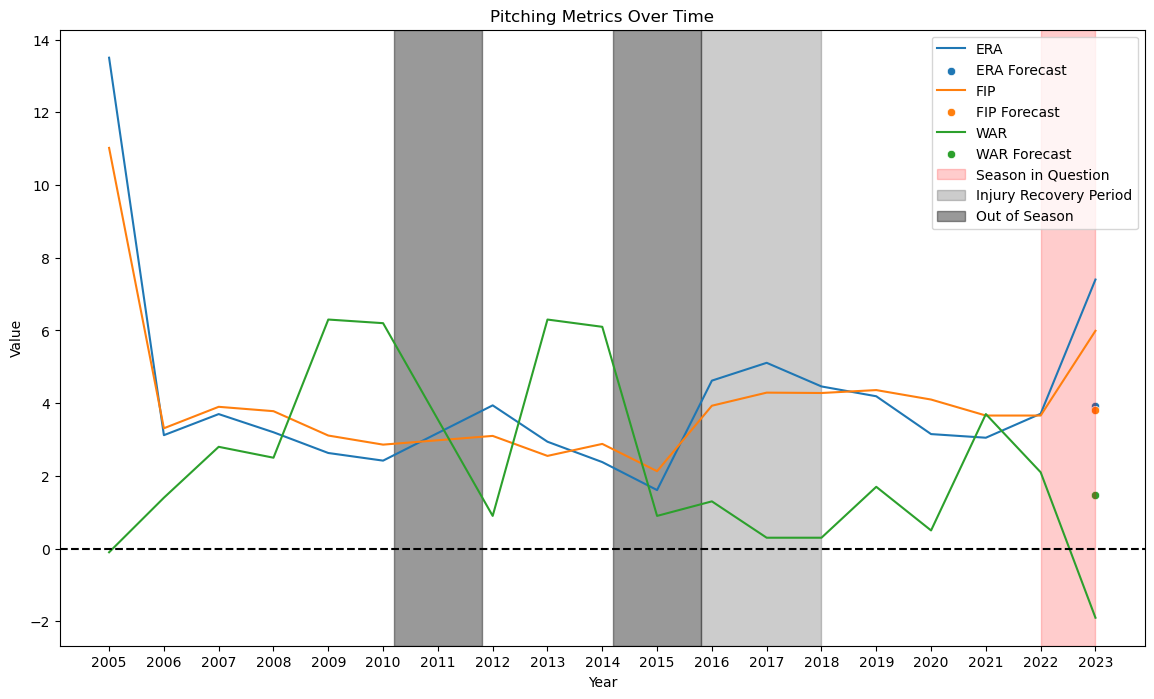

In [37]:
plt.figure(figsize=(14, 8))
for metric in ['ERA', 'FIP', 'WAR']:
    sns.lineplot(data=wainoStats, x='Season', y=metric, label=metric)
    
    # Plot the forecasted data for the same metric
    sns.scatterplot(
        data=plotForecast[plotForecast['Metric'] == metric],  # Ensure predictions are for the same metric
        x='Season', 
        y='Prediction', 
        label=f'{metric} Forecast'
    )
plt.xticks(range(2005, 2024))
plt.axvspan(2022, 2023, color='red', alpha=.2, label='Season in Question')
plt.axvspan(2015.8, 2018, color='black', alpha=.2, label='Injury Recovery Period')
plt.axvspan(2014.2, 2015.8, color='black', alpha=.4)
plt.axvspan(2010.2, 2011.8, color='black', alpha=.4, label='Out of Season')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
plt.title('Pitching Metrics Over Time')
plt.ylabel('Value')
plt.xlabel('Year')
plt.legend()
plt.show()

In [38]:
#Appendix:
print(wainoStats.columns)
#print(wainoStats)
print(waino.columns.tolist())
print(wainoAvgs.columns.tolist())
print(compPitchersStats.columns.tolist())
print(type(compPitchersStats))
print(modelingWainoStats)
modelingWainoStats.isna().sum()

Index(['Season', 'Age', 'Team', 'Lg', 'WAR', 'W', 'L', 'W-L%', 'ERA', 'G',
       'GS', 'GF', 'CG', 'SHO', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB',
       'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9', 'HR9',
       'BB9', 'SO9', 'SO/BB', 'Awards'],
      dtype='object')
['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'rele

Age                0
WAR                0
W                  0
L                  0
ERA                0
G                  0
GS                 0
GF                 0
CG                 0
SHO                0
SV                 0
IP                 0
H                  0
R                  0
ER                 0
HR                 0
BB                 0
IBB                0
SO                 0
HBP                0
BK                 0
WP                 0
BF                 0
ERA+               0
FIP                0
WHIP               0
H9                 0
HR9                0
BB9                0
SO9                0
SO/BB              0
CH_Avg_Velocity    0
CU_Avg_Velocity    0
FC_Avg_Velocity    0
FF_Avg_Velocity    0
SI_Avg_Velocity    0
dtype: int64